# Overfit and underfit
- Learn how to prevent overfitting/underfitting and explore several common regularization techniques using TensorFlow Keras API.
- Full tutorial reference: https://www.tensorflow.org/tutorials/keras/overfit_and_underfit

### Import TensorFlow and necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.9.1


### The Higgs dataset

In [2]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [3]:
# the dataset contains 11,000,000 examples, each with 28 features, and a binary class label
FEATURES = 28
ds = tf.data.experimental.CsvDataset(gz, [float(),]*(FEATURES+1), compression_type='GZIP')

In [4]:
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:], axis=1) # packs the list of tensors into a tensor with rank one higher
    return features, label

In [5]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

In [6]:
packed_ds.element_spec

(TensorSpec(shape=(28,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.float32, name=None))

In [7]:
# use the first 1,000 samples for validation, and the next 10,000 for training
N_VALIDATION = 1000
N_TRAIN = 10000
BUFFER_SIZE = 1000
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [8]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [9]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

### Training procedure
- *tf.keras.optimizers.schedule* to reduce the learning rate over time
- *tf.docs.EpochDots* to reduce the logging noise
- *tf.keras.callbacks.EarlyStopping* to avoid long and unnecessary training times

In [10]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False
)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

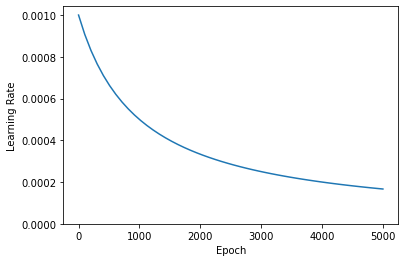

In [37]:
step = np.linspace(0,100000)
lr = lr_schedule(step)

plt.figure()
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()

### Model training configuration

In [11]:
def get_callbacks():
    return [tfdocs.modeling.EpochDots(), 
            tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200)]

In [12]:
def compile_and_fit(model, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
        
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
        metrics=[tf.keras.losses.BinaryCrossentropy(from_logits=True, name='binary_crossentropy'), 'accuracy']
    )

    model.summary()

    history = model.fit(
        train_ds,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_data=validate_ds,
        callbacks=get_callbacks(),
        verbose=0
    )
    return history

### Create dictionary for storing models

In [14]:
models = {}

### Tiny model

In [15]:
tiny_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    tf.keras.layers.Dense(1)
])

models['tiny_model'] = compile_and_fit(tiny_model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                464       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4775,  binary_crossentropy:0.8094,  loss:0.8094,  val_accuracy:0.4870,  val_binary_crossentropy:0.7629,  val_loss:0.7629,  
....................................................................................................
Epoch: 100, accuracy:0.6013,  binary_crossentropy:0.6240,  loss:0.6240,  val_accuracy:0.5790,  val_binary_crossentropy:0.6315,  val_loss:0.6315,  
............................................................

In [19]:
plotter = tfdocs.plots.HistoryPlotter(metric='binary_crossentropy', smoothing_std=10)

### Small model

In [42]:
small_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(1)
])

models['small_model'] = compile_and_fit(small_model)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16)                464       
                                                                 
 dense_5 (Dense)             (None, 16)                272       
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4863,  binary_crossentropy:0.7202,  loss:0.7202,  val_accuracy:0.4690,  val_binary_crossentropy:0.7029,  val_loss:0.7029,  
....................................................................................................
Epoch: 100, accuracy:0.6257,  binary_crossentropy:0.6122,  loss:0.6122,  

### Medium model

In [43]:
medium_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    tf.keras.layers.Dense(64, activation='elu'),
    tf.keras.layers.Dense(64, activation='elu'),
    tf.keras.layers.Dense(1)
])

models['medium_model'] = compile_and_fit(medium_model)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 64)                1856      
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4826,  binary_crossentropy:0.6970,  loss:0.6970,  val_accuracy:0.4740,  val_binary_crossentropy:0.6796,  val_loss:0.6796,  
....................................

### Large model

In [44]:
large_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dense(1),
])

models['large_model'] = compile_and_fit(large_model)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 512)               14848     
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 dense_13 (Dense)            (None, 512)               262656    
                                                                 
 dense_14 (Dense)            (None, 512)               262656    
                                                                 
 dense_15 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5184,  binary_crossentropy

### Plot the training and validation losses
- The solid lines show the training loss, and the dashed lines show the validation loss (**Reminder**: lower validation loss indicates a better model)
- In the plot below, only the ```tiny_model``` manages to avoid overfitting completely, and each of the larger models overfit the data more quickly. 
- If the validation metric begins to stagnate while the training metric keeps to improve, or if the validation metric is going in the wrong direction, the model starts overfitting. 

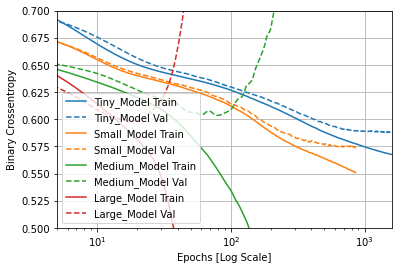

In [45]:
plotter.plot(models)
plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")
plt.show()

In [16]:
regularizer_models = {}
regularizer_models['tiny_model'] = models['tiny_model']

### Strategies to prevent overfitting
1. Add weight regularization known as L1 regularization or L2 regularization
2. Add dropout layer

### Weight regularization
- "Weight regularization is a common way to mitigate overfitting where it puts constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more regular."
- L1 regularization adds the absolute value of the weights coefficients to the loss function whereas L2 regularization puts the square of the value of the weights coefficients to the loss function. In neural network, L2 regularization is also known as 'weight decay'. 
- "L1 regularization pushes weights towards exactly zero, encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights—one reason why L2 is more common."

In [47]:
l2_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='elu',
                          kernel_regularizer=tf.keras.regularizers.l2(0.001), # pass tf.keras.regularizers as keyword arguments
                          input_shape=(FEATURES,)),
    tf.keras.layers.Dense(512, activation='elu',
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(512, activation='elu',
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(512, activation='elu',
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(1),
])

# l2(0.001) means every coefficient in the weight matrix of the layer will add 0.001 * squared(weight_coeff)

regularizer_models['l2_model'] = compile_and_fit(l2_model)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 512)               14848     
                                                                 
 dense_17 (Dense)            (None, 512)               262656    
                                                                 
 dense_18 (Dense)            (None, 512)               262656    
                                                                 
 dense_19 (Dense)            (None, 512)               262656    
                                                                 
 dense_20 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5018,  binary_crossentropy

(0.5, 0.7)

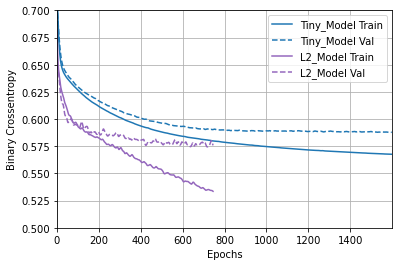

In [48]:
plotter.plot(regularizer_models)
plt.ylim([0.5, 0.7])

### Dropout
- Dropout is one of the most effective regularization techniques for neural networks. During training, the dropout randomly sets a number of output features to zero (dropping out) based on the dropout rate (the fraction of the features that are being zeroed-out).

In [49]:
dropout_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    tf.keras.layers.Dropout(0.5), # add tf.keras.layers.Dropout 
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1),
])

regularizer_models['dropout_model'] = compile_and_fit(dropout_model)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 512)               14848     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_23 (Dense)            (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_24 (Dense)            (None, 512)              

(0.5, 0.7)

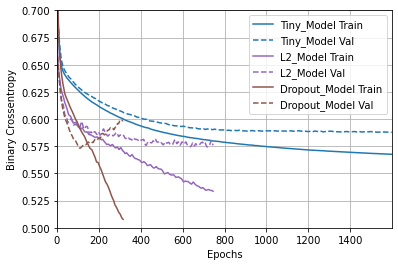

In [51]:
plotter.plot(regularizer_models)
plt.ylim([0.5, 0.7])

### Combined L2 regularization and dropout

In [17]:
combined_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='elu',
                          kernel_regularizer=tf.keras.regularizers.l2(0.001),
                          input_shape=(FEATURES,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='elu',
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='elu',
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='elu',
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1),
])

regularizer_models['combined_model'] = compile_and_fit(combined_model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 512)               14848     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 512)              

(0.5, 0.7)

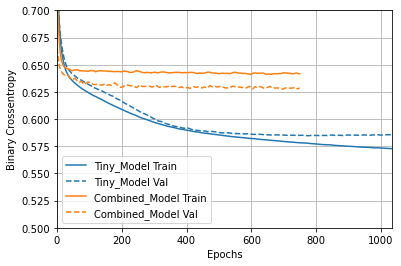

In [20]:
plotter.plot(regularizer_models)
plt.ylim([0.5, 0.7])

### Conclusion
- The best and most common ways to prevent overfitting in neural networks:
    - Get more training data
    - Reduce the capacity (the number of layers and parameters) of the network
    - Add weight regularization (L2 regularization)
    - Add dropout technique
    
- Important to notice that combining various techniques can be even more effective to prevent overfitting.

In [21]:
# MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.